<a href="https://colab.research.google.com/github/MarvNC/cs523/blob/main/s25_chapter7_handout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preface

Unfortunately, the `ce.TargetEncoder` seen in video has gone out of date; the `category_encoders` library does not appear to be adequately maintained. I will help you implement target-encoding from scratch in a custom encoder. It is not too bad and enlightening to see what is happening behind the scenes. And you know it will not go out of date!

It is also the case that I will ask you to override two of your results in this notebook: random numbers to do data splitting. I am doing this to stay consistent with videos. In Challenge 5 I will explain more.

Finally, I created a detailed description of the pipeline we are using. I think it is important for the end-user to know how we wrangled the data. Keep a note of it: I will ask you to recreate it for your own dataset in the final project.

<center>
<h1>Chapter Seven</h1>
</center>

<hr>

## LEARNING OBJECTIVES:
- Need to update Pipeline, replacing one-hot encoding with target encoding. Discussion of target encoding principles.
- Pivot from wrangling to modeling (prediction, classification).
- Use of train-test split concept to evaluate our models.
- Tune one of `train_test_split` function's parameters, `random_state`, using variance modeling.
- Concept of *data leakage* and how to avoid it.
- Exploration of another of `train_test_split` function's parameters, `test_size`, and results compared to a published article.

# I. First steps toward modeling - data split

This chapter is a bridge between wrangling and exploring machine learning models to predict (AKA classify). It introduces a key step in supervised learning: splitting data into a training set and a test set.

Let's go ahead and bring in the raw dataset.


## Set-up

First bring in your library.

In [1]:
github_name = 'MarvNC'
repo_name = 'cs523'
source_file = 'library.py'
url = f'https://raw.githubusercontent.com/{github_name}/{repo_name}/main/{source_file}'
# !rm $source_file
# !wget $url
# %run -i $source_file
from library import *

In [2]:
type(CustomKNNTransformer)  #from last chapter

type

In [3]:
url = 'https://raw.githubusercontent.com/fickas/asynch_models/refs/heads/main/datasets/titanic_trimmed.csv'

titanic_trimmed = pd.read_csv(url)
len(titanic_trimmed)

1313

In [4]:
titanic_features = titanic_trimmed.drop(columns='Survived')
titanic_features.head()  #print first 5 rows of the table

,Age,Gender,Class,Joined,Married,Fare
0,41.0,Male,C3,Southampton,0.0,7.0
1,21.0,Male,Crew,Southampton,0.0,0.0
2,13.0,Male,C3,Southampton,NaN,20.0
3,16.0,Male,C3,Southampton,0.0,NaN
4,NaN,Male,C2,Cherbourg,0.0,24.0


In [5]:
labels = titanic_trimmed['Survived'].to_list()

# II. The foundation of model exploration: the train-test split

Here is the problem. Assume we have historical data, i.e., data about what is happened in the past. We either collected it by hand (Titanic) or automatically logged it (Cable customers). We will assume that the data is "labeled". That means we know the outcome. So we know who survived. We know how customers rated their cable experience. We know how a medical diagnosis turned out. This is a big assumption. It puts the problem into what is called **Supervised Learning**. What if we are lacking labels, i.e., we do not know how things turned out? Then we fall under **Unsupervised Learning**. We will focus on Supervised Learning in this class. You might want to take a Data Mining class if you are interested in Unsupervised Learning.

<img src='https://dfzljdn9uc3pi.cloudfront.net/2020/10317/1/fig-1-2x.jpg' height=250>

The problem is that we want to train a model with our historical data so that it can predict future (as yet unseen) data. And btw, this future data will not be labeled. We have to predict the label! So we won't know if we are right or wrong (at least not immediately).

One solution is to break our dataset into 2 pieces: a training set and a test set. We hold out the test set to act as the "future" data. The beauty of this is that this test set is labeled. So we can judge how we might do in the future. And have ammunition when we take it to the customer (a cable company, a medical clinic) that we will do a good job when they put our model into production.


# III. How to split?

The simplest is to randomly choose some portion of the dataset to use for training and the remainder to set aside for testing. And sklearn has a function to do that. Check it out.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(titanic_features,   #all columns except target column
                                                    labels,             #a list of values from target column, e.g., Survived
                                                    test_size=0.2,      #percent to put in test set
                                                    shuffle=True,        #whether to randomly shuffle rows (and labels) first
                                                    random_state=0)     #a seed for the random shuffle

Notice that I use `test_size=0.2` to say I want to hold 20% of the dataset out for testing. This is a hyperparameter that you can change. Also notice that I use `shuffle=True` to say I want a random (shuffled) selection.

Let's see what is produced.


In [7]:
X_train.head()  #differs from video

,Age,Gender,Class,Joined,Married,Fare
1078,16.0,Female,C1,Cherbourg,0.0,39.0
1121,30.0,Male,C1,Cherbourg,0.0,57.0
772,18.0,Female,C1,Cherbourg,1.0,247.0
44,31.0,Male,C2,Southampton,1.0,26.0
1075,38.0,Male,Crew,Belfast,1.0,0.0


In [8]:
y_train[:10]   #training labels that go with X_train

[1, 1, 1, 0, 1, 1, 1, 0, 1, 1]

# IV. We have an issue with One-hot encoding now

The problem is that one-hot encoding adds new columns. What if `X_test` has a different set of categories than `X_train`? Maybe `X_train` is missing `'Belfast'` in the `Joined` column. If we apply `CustomOHETransformer` to `X_train` and `X_test` separately, we could end up with two tables that do not match in their features. That would be bad.

One (complicated) solution is to rewrite CustomOHETransformer to deal with this. It would end up adding and/or removing columns to X_test. Kind of ugly.

I am going to present several alternative approaches for handling nominal columns. **Note this greatly expands the video**.


### First up is `ce.TargetEncoder`  (what is seen in video)

<pre>
!pip install category_encoders
import category_encoders as ce
</pre>

Here is how the simple target-encoding algorithm works.

1. Choose a category from a nominal column, e.g., `Belfast` from `Joined`.
2. Find all rows with `Belfast` and record the `Survived` value (AKA the target value). Compute average of the values. Given that `Survived` is a binary column, we will get the percentage of 1s.
3. Map all Belfast values in the column to this percentage.
4. Repeat for all categories in the column.

Notice that the column is scaled between 0 and 1 once we finish. So that is good.

For a deeper dive see [foundational paper](https://dl.acm.org/doi/10.1145/507533.507538).

### Problems with target encoding

We need something called smoothing that maybe best shown with an example. First here is formula:

* Smoothing Formula: `(n * category_mean + smoothing * global_mean) / (n + smoothing)`

Consider an extreme example:

* Category A appears 1000 times, with target mean 0.5
* Category B appears only 2 times, with target mean 1.0

**Without smoothing**:

We will confidently assign 1.0 to Category B.
This is risky because those 2 samples might be outliers.
You're essentially trusting 2 samples as much as 1000 samples

**With smoothing (like in `ce.TargetEncoder`)**:

Category B's encoding would be pulled toward the global mean.
So Category B might get 0.6 instead of 1.0, making it more conservative.

**Real-world impact of lack of smoothing**:

* Small/rare categories can cause overfitting without smoothing. (More on this later.)
* Cross-validation scores might look deceptively good. (More on this later.)
* Production performance could degrade, especially if rare categories are important.

### The good and bad news (problems encountered post-video)

The `ce.TargetEncoder` indeed does smoothing so is a great fit for our pipeline. The bad news is that it has lost compatibility (since the video) with Colab. Once you try to `fit_transform`, you will get an error. I suppose the lesson is that you (and I) need to be careful when relying on libraries that might not be actively maintained.

## Next up is MeanEncoder (not seen in video)

<pre>
from feature_engine.encoding import MeanEncoder

# Set unseen='ignore' to encode new categories as nan
encoder = MeanEncoder(
    variables=['categorical_column'],
    unseen='ignore'  # This will make it return np.nan for unseen values
)
</pre>

### More good and bad news

The `feature_engine` library is well maintained and `MeanEncoder` will work for us. The bad news is that it uses the simple target encoding algorithm without smoothing. I think smoothing is important so will not consider the `MeanEncoder`.

## sklearn (kind of) to the rescue

The sklearn library does have a target-encoder:

<pre>
from sklearn.preprocessing import _encoders
encoder = _encoders.TargetEncoder(cols=['your_categorical_column'], smoothing=1.0)  
</pre>

However, it is experimental and could change (or go away), so will not be using it.

## Write our own (not seen in video)

The target encoding algorithm, even with smoothing, is not too bad. Let's just implement it in a custom class.

A note about the smoothing parameter.
The smoothing parameter controls how much weight to give to the global mean:

* Higher values (e.g., 100) = more smoothing, encodings closer to global mean.
*Lower values (e.g., 1) = less smoothing, encodings closer to category means.

A good starting point is often around 10-20.

### The code is a bit obscure in `fit` method below

Let's go through it with simple example.



In [9]:
# Sample data
X_ = pd.DataFrame({
    'neighborhood': ['Downtown', 'Suburbs', 'Downtown', 'Rural', 'Downtown', 'Suburbs', 'Downtown', 'Rural'],
    'target': [1, 0, 1, 0, 1, 0, 0, 1]  # 1 = expensive, 0 = not expensive
})
X_

,neighborhood,target
0,Downtown,1
1,Suburbs,0
2,Downtown,1
3,Rural,0
4,Downtown,1
5,Suburbs,0
6,Downtown,0
7,Rural,1


In [10]:
# When we do:
X_['target'].groupby(X_['neighborhood']).mean()

neighborhood
Downtown    0.75
Rural       0.50
Suburbs     0.00
Name: target, dtype: float64

In [11]:
# Then turn into dict
means = X_['target'].groupby(X_['neighborhood']).mean().to_dict()

In [12]:
# We get
means

{'Downtown': 0.75, 'Rural': 0.5, 'Suburbs': 0.0}

In [13]:
#And when we apply smoothing:

global_mean = X_['target'].mean()  # overall proportion of expensive houses
global_mean # 0.5 (4 expensive out of 8 total)

0.5

In [14]:
counts = X_['neighborhood'].value_counts().to_dict()
counts # {'Downtown': 4, 'Suburbs': 2, 'Rural': 2}


{'Downtown': 4, 'Suburbs': 2, 'Rural': 2}

### Apply smoothing

In [ ]:
smoothing = 10
# For each category Calculate smoothed mean
smoothed_means = {}
for category in counts.keys():
    category_count = counts[category]
    category_mean = means[category]
    # Apply smoothing formula: (n * cat_mean + m * global_mean) / (n + m)
    smoothed_mean = (category_count * category_mean + smoothing * global_mean) / (category_count + smoothing)
    smoothed_means[category] = smoothed_mean

# Downtown: (4 * 0.75 + 10 * 0.5) / (4 + 10) = 0.571
# Less extreme than 0.75 due to smoothing

# Suburbs: (2 * 0.0 + 10 * 0.5) / (2 + 10) = 0.417
# Pulled up from 0.0 toward global mean

# Rural: (2 * 0.5 + 10 * 0.5) / (2 + 10) = 0.5
# Stays at 0.5 since it equals global mean

smoothed_means


{'Downtown': 0.5714285714285714, 'Suburbs': 0.4166666666666667, 'Rural': 0.5}

</pre>
The smoothing is especially important with binary targets because:

* Small sample sizes can give extreme proportions (0% or 100%).
* These extreme values might not generalize well.
* Smoothing pulls these proportions toward the global mean.

### Be lazy - make pandas do the work

Note I am using built-in pandas methods when I can in code below - let them do the work for me.

In [17]:
class CustomTargetTransformer(BaseEstimator, TransformerMixin):
    """
    A target encoder that applies smoothing and returns np.nan for unseen categories.

    Parameters:
    -----------
    col: name of column to encode.
    smoothing : float, default=10.0
        Smoothing factor. Higher values give more weight to the global mean.
    """

    def __init__(self, col: str, smoothing: float =10.0):
        self.col = col
        self.smoothing = smoothing
        self.global_mean_ = None
        self.encoding_dict_ = None

    def fit(self, X, y):
        """
        Fit the target encoder using training data.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training data features.
        y : array-like of shape (n_samples,)
            Target values.
        """
        assert isinstance(X, pd.core.frame.DataFrame), f'{self.__class__.__name__}.fit expected Dataframe but got {type(X)} instead.'
        assert self.col in X, f'{self.__class__.__name__}.fit column not in X: {self.col}. Actual columns: {X.columns}'
        assert isinstance(y, Iterable), f'{self.__class__.__name__}.fit expected Iterable but got {type(y)} instead.'
        assert len(X) == len(y), f'{self.__class__.__name__}.fit X and y must be same length but got {len(X)} and {len(y)} instead.'

        #Create new df with just col and target - enables use of pandas methods below
        X_ = X[[self.col]]
        target = self.col+'_target_'
        X_[target] = y

        # Calculate global mean
        self.global_mean_ = X_[target].mean()

        # Get counts and means
        counts = X_[self.col].value_counts().to_dict()    #dictionary of unique values in the column col and their counts
        means = X_[target].groupby(X_[self.col]).mean().to_dict() #dictionary of unique values in the column col and their means

        # Calculate smoothed means
        smoothed_means = {}
        for category in counts.keys():
            n = counts[category]
            category_mean = means[category]
            # Apply smoothing formula: (n * cat_mean + m * global_mean) / (n + m)
            smoothed_mean = (n * category_mean + self.smoothing * self.global_mean_) / (n + self.smoothing)
            smoothed_means[category] = smoothed_mean

        self.encoding_dict_ = smoothed_means

        return self

    def transform(self, X):
        """
        Transform the data using the fitted target encoder.
        Unseen categories will be encoded as np.nan.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Input data to transform.
        """

        assert isinstance(X, pd.core.frame.DataFrame), f'{self.__class__.__name__}.transform expected Dataframe but got {type(X)} instead.'
        assert self.encoding_dict_, f'{self.__class__.__name__}.transform not fitted'

        X_ = X.copy()

        # Map categories to smoothed means, naturally producing np.nan for unseen categories, i.e.,
        # when map tries to look up a value in the dictionary and doesn't find the key, it automatically returns np.nan. That is what we want.
        X_[self.col] = X_[self.col].map(self.encoding_dict_)

        return X_

    def fit_transform(self, X, y):
        """
        Fit the target encoder and transform the input data.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training data features.
        y : array-like of shape (n_samples,)
            Target values.
        """
        return self.fit(X, y).transform(X)

### Small demo of use

I'll fit with training data then transform test data. This mirrors what we will be doing once we split into train and test sets.

In [18]:
demo_df = pd.DataFrame({
    'A': ['cat', 'snake', 'dog'],
    'target': [1, 0, 1]
})
demo_df


,A,target
0,cat,1
1,snake,0
2,dog,1


In [19]:
#fit with train_df
target_encoder = CustomTargetTransformer(col='A', smoothing=10)
target_encoder.fit(demo_df, demo_df['target'])

CustomTargetTransformer(col='A', smoothing=10)

In [20]:
demo_df2 = pd.DataFrame({
    'A': ['cat', 'snake', 'bear'],
    'target': [0, 1, 0]
})
demo_df2


,A,target
0,cat,0
1,snake,1
2,bear,0


In [21]:
# Transforming with test_df
test_encoded = target_encoder.transform(demo_df2)

test_encoded  #notice that 'bear' leads to NaN given it was not seen in train_df

,A,target
0,0.696970,0
1,0.606061,1
2,NaN,0


I propose we swap out our `CustomOHETransformer` and use the `CustomTargetTransformer` instead going forward. You will need to edit your library pipelines accordingly.

# V. Stratified splitting

With a random split, we do not know what will be in the test set. What if I want the test set to have the same distribution of labels as the training set? With plain random, I could end up with a test set of just those who perished. Or just customers who always rate highly. What I would like is for the same distribution. So if the overall dataset has 65% negative labels and 35% positive, I would like both the training and test sets to carry that distribution. Make sense?

<img src='https://www.datasciencemadesimple.com/wp-content/uploads/2020/02/Stratified-Sampling-in-SAS-0.png?ezimgfmt=ng%3Awebp%2Fngcb1%2Frs%3Adevice%2Frscb1-1' height=100>

Good news: it is not hard to do. We just need to add a parameter to what we have. Check it out.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(titanic_features, labels, test_size=0.2, shuffle=True,
                                                    random_state=0,
                                                    stratify=labels)  #added parameter

Reminder: `labels = titanic_trimmed['Survived'].to_list()`

# VI. Splitting on `random_state`

This is the article that introduces this idea: [Variance splitting](https://towardsdatascience.com/future-proof-your-data-partitions-d2047de9ead2).  The general idea is that we write a loop that tries different splits by changing the `random_state` value. For each separate value, we train a model and predict on both training and test data. We log the test accuracy divided by the training accuracy, i.e., how far they vary.

If we loop 200 times, we will get 200 variances. We take the average.  We now choose whatever value for `random_state` gets us closest to that average.

The code is not too bad so let's try it. One problem is that we need to wrangle the raw titanic dataset to get to spot where we can loop. I'll do that now. Notice the imputation step has been added and target encoding now in play.

In [24]:
#Only instantiating once then passing in as parameter. See "Caveat" below.

titanic_transformer = Pipeline(steps=[
    ('map_gender', CustomMappingTransformer('Gender', {'Male': 0, 'Female': 1})),
    ('map_class', CustomMappingTransformer('Class', {'Crew': 0, 'C3': 1, 'C2': 2, 'C1': 3})),
    ('target_joined', CustomTargetTransformer(col='Joined', smoothing=10)),   #swapped this in
    ('tukey_age', CustomTukeyTransformer(target_column='Age', fence='outer')),
    ('tukey_fare', CustomTukeyTransformer(target_column='Fare', fence='outer')),
    ('scale_age', CustomRobustTransformer(target_column='Age')),
    ('scale_fare', CustomRobustTransformer(target_column='Fare')),
    ('impute', CustomKNNTransformer(n_neighbors=5)),
    ], verbose=True)



### The choice of model we use is up to us

Remember, we are not trying to find the best accuracy. That comes in later chapters. We are trying to produce a set of variances that we can use to find an average.

I am going to choose KNN because we have already seen it in action in the `KNNImputer`. There is a version that will predict the value of a specific column, in our case, `Survived`. Uses the same crowd sourcing idea we discussed last chapter.

In [25]:
from sklearn.neighbors import KNeighborsClassifier  #the KNN model
model = KNeighborsClassifier(n_neighbors=5)  #instantiate with k=5.

### The choice of goodness metric is up to us

We could choose just plain accuracy. But
I am going to use something called the F1 score because it is so common.
The higher the F1 score, the better. The value 1 is perfect. But remember, we are looking at this ratio: test_F1/train_F1. Our goal is to compute the average ratio across 200 tries. So we really are not concerned with the F1 values, just the average ratio.

That said, F1 can be misleading with unbalanced data. I almost replaced it with MCC or ROC-AUC, both of which we will discuss later.

## Caveat

I am only instantiating the `Pipeline` once (see code above) and passing it in. This means the `Pipeline` only instantiates each transformer once. So when we do a `transformer.fit_transform` in the loop body, we are counting on the `fit` method in each transformer to reset its state. Otherwise, calling `fit` repeatedly in the loop could lead to undesired accumulation of state in the transformer object. Make sense?

I am confident that each of our transformers resets its state information on a call to `fit` so I think we are good. But it is something to be aware of. The alternative is to place the entire `Pipeline` definition (see code above) within the loop body so we get a fresh pipeline every time through the loop.

In [26]:
from sklearn.metrics import f1_score  #typical metric used to measure goodness of a model

In [27]:
def find_random_state_old(features_df, labels, transformer, n=200):
  model = KNeighborsClassifier(n_neighbors=5)

  ratios = []  #collect test_f1/train_f1 values
  for i in range(0, n):
    train_X, test_X, train_y, test_y = train_test_split(features_df, labels, test_size=0.2, shuffle=True,
                                                    random_state=i, stratify=labels)

    #apply pipeline
    transform_train_X = transformer.fit_transform(train_X, train_y)
    transform_test_X = transformer.transform(test_X)

    #train model then predict
    model.fit(transform_train_X, train_y)  #train model
    train_pred = model.predict(transform_train_X)  #predict against training set
    test_pred = model.predict(transform_test_X)    #predict against test set
    train_f1 = f1_score(train_y, train_pred)  #how well did we do with prediction on training data?

    if train_f1 < .1:
        continue  # Skip if train_f1 is too low or zero

    test_f1 = f1_score(test_y, test_pred)     #how well did we do with prediction on test data?
    f1_ratio = test_f1/train_f1        #take the ratio - closer to 1 the better
    ratios.append(f1_ratio)

  mean = np.mean(ratios)
  rs_value = np.abs(ratios - mean).argmin()  # Returns index of value closest to mean

  return rs_value, ratios


In [28]:
def find_random_state(
    features_df: pd.DataFrame,
    labels: Iterable,
    transformer: TransformerMixin,
    n: int = 200
                  ) -> Tuple[int, List[float]]:
    """
    Finds an optimal random state for train-test splitting based on F1-score stability.

    This function iterates through `n` different random states when splitting the data,
    applies a transformation pipeline, and trains a K-Nearest Neighbors classifier.
    It calculates the ratio of test F1-score to train F1-score and selects the random
    state where this ratio is closest to the mean.

    Parameters
    ----------
    features_df : pd.DataFrame
        The feature dataset.
    labels : Union[pd.Series, List]
        The corresponding labels for classification (can be a pandas Series or a Python list).
    transformer : TransformerMixin
        A scikit-learn compatible transformer for preprocessing.
    n : int, default=200
        The number of random states to evaluate.

    Returns
    -------
    rs_value : int
        The optimal random state where the F1-score ratio is closest to the mean.
    Var : List[float]
        A list containing the F1-score ratios for each evaluated random state.

    Notes
    -----
    - If the train F1-score is below 0.1, that iteration is skipped.
    - A higher F1-score ratio (closer to 1) indicates better train-test consistency.
    """

    model = KNeighborsClassifier(n_neighbors=5)
    Var: List[float] = []  # Collect test_f1/train_f1 ratios

    for i in range(n):
        train_X, test_X, train_y, test_y = train_test_split(
            features_df, labels, test_size=0.2, shuffle=True,
            random_state=i, stratify=labels  # Works with both lists and pd.Series
        )

        # Apply transformation pipeline
        transform_train_X = transformer.fit_transform(train_X, train_y)
        transform_test_X = transformer.transform(test_X)

        # Train model and make predictions
        model.fit(transform_train_X, train_y)
        train_pred = model.predict(transform_train_X)
        test_pred = model.predict(transform_test_X)

        train_f1 = f1_score(train_y, train_pred)

        if train_f1 < 0.1:
            continue  # Skip if train_f1 is too low

        test_f1 = f1_score(test_y, test_pred)
        f1_ratio = test_f1 / train_f1  # Ratio of test to train F1-score

        Var.append(f1_ratio)

    mean_f1_ratio: float = np.mean(Var)
    rs_value: int = np.abs(np.array(Var) - mean_f1_ratio).argmin()  # Index of value closest to mean

    return rs_value, Var


# My apologies

Something has changed within the KNN classifier since I created the videos and the notebooks. You will see in the video that I get results below that do not match the new reality.

Your goal is to match what I have in the notebook, not the video. Sorry about that. But libraries change often in ML land and sometimes without warning.

In [29]:
%%capture
titanic_rs, all_values = find_random_state(titanic_features, labels, titanic_transformer)

In [30]:
titanic_rs  #24 gives us value closest to mean of all_values

112

### Just to check

In [31]:
np.mean(all_values)  #0.8511360176628843

0.8499657769563719

In [32]:
all_values[24]  #0.851497005988024

0.8380035981028187

### Here is plot to visualize

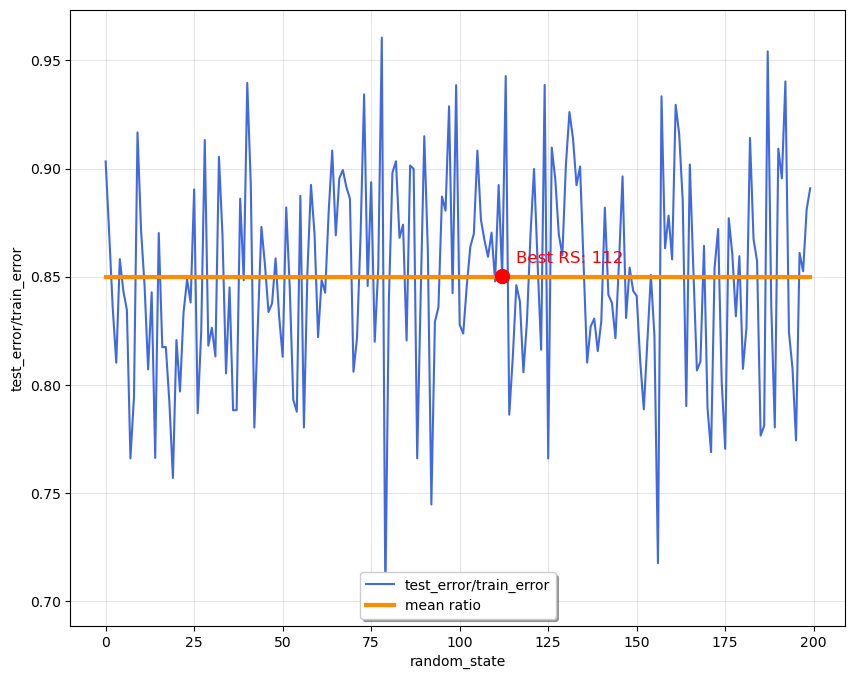

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))

# Original plots
plt.plot(range(0, 200), all_values, color='royalblue', label="test_error/train_error")
plt.plot([0, 199], [np.mean(all_values), np.mean(all_values)],
         color='darkorange', linewidth=3, label="mean ratio")

# Add point at best random state
plt.scatter(titanic_rs, all_values[titanic_rs], color='red', s=100, zorder=5)

# Add annotation for the value
plt.annotate(f'Best RS: {titanic_rs}',
            xy=(titanic_rs, all_values[titanic_rs]),
            xytext=(10, 10),
            textcoords='offset points',
            color='red',
            fontsize=12)

plt.xlabel('random_state')
plt.ylabel('test_error/train_error')
plt.legend(loc='lower center', shadow=True, fontsize='medium')
plt.grid(True, alpha=0.3)
plt.show()

# VII. Ready for final split but consider data leakage

We know what `random_state` value to use. Let's do the split using it.

The next issue is of data leakage. We do not want any info on the test set to leak into the training set. Where could this happen? In our pipeline. If we are not careful, when we compute scale and impute values, we might end up including the test set in these computations. That would be bad. For instance, we could end up imputing missing values in the training set by relying on information in the test set. We want a firewall between training and testing sets. Transforms on the training set do not get to look at the test set for help.

The good news is that our transformers take this into account. That is why some have a `fit` step. We should fit with the training set only. Then we can transform both the training and test sets from that without leakage.



In [34]:
X_train, X_test, y_train, y_test = train_test_split(titanic_features, labels, test_size=0.2, shuffle=True,
                                                    random_state=titanic_rs, stratify=labels)

### Reality check on stratification of other columns

We chose to stratify on `Survived`. But might be worth looking at feature columns to see if they are roughly stratified as well.

In [35]:
X_train.describe(include='all').T.round(2)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1043.0,NaN,NaN,NaN,31.202301,14.196466,1.0,22.0,30.0,41.0,71.0
Gender,1050,2,Male,676,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Class,1049,4,C3,418,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Joined,1050,4,Southampton,709,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Married,1049.0,NaN,NaN,NaN,0.348904,0.476851,0.0,0.0,0.0,1.0,1.0
Fare,1048.0,NaN,NaN,NaN,31.613779,52.814403,0.0,7.0,14.0,30.25,512.0


In [36]:
X_test.describe(include='all').T.round(2)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,261.0,NaN,NaN,NaN,33.061303,14.86827,1.0,23.0,31.0,42.0,74.0
Gender,263,2,Male,179,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Class,263,4,C3,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Joined,263,4,Southampton,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Married,263.0,NaN,NaN,NaN,0.323194,0.468588,0.0,0.0,0.0,1.0,1.0
Fare,263.0,NaN,NaN,NaN,29.408897,51.721454,0.0,7.0,13.0,30.5,512.0


Just eyeballing the two tables with the mean and std, it looks like a fairly balanced distribution among the two sets. Also, the `Joined` column has all 4 possible values in the training set. See my argument above that we should be able to guarantee this if we rewrote `train_test_split`. Or at least throw an error if it is not the case.

# VIII. Apply pipeline to X_train

Do a `fit_transform` and remember to pass in labels as 2nd argument.

In [37]:
titanic_transformer = Pipeline(steps=[
    ('map_gender', CustomMappingTransformer('Gender', {'Male': 0, 'Female': 1})),
    ('map_class', CustomMappingTransformer('Class', {'Crew': 0, 'C3': 1, 'C2': 2, 'C1': 3})),
    ('target_joined', CustomTargetTransformer(col='Joined', smoothing=10)),
    ('tukey_age', CustomTukeyTransformer(target_column='Age', fence='outer')),
    ('tukey_fare', CustomTukeyTransformer(target_column='Fare', fence='outer')),
    ('scale_age', CustomRobustTransformer('Age')),
    ('scale_fare', CustomRobustTransformer('Fare')),
    ('impute', CustomKNNTransformer(n_neighbors=5)),
    ], verbose=True)



In [38]:
X_train_transformed = titanic_transformer.fit_transform(X_train, y_train)   #need both arguments for fit


[Pipeline] ........ (step 1 of 8) Processing map_gender, total=   0.0s


[Pipeline] ......... (step 2 of 8) Processing map_class, total=   0.0s
[Pipeline] ..... (step 3 of 8) Processing target_joined, total=   0.0s
[Pipeline] ......... (step 4 of 8) Processing tukey_age, total=   0.0s
[Pipeline] ........ (step 5 of 8) Processing tukey_fare, total=   0.0s
[Pipeline] ......... (step 6 of 8) Processing scale_age, total=   0.0s
[Pipeline] ........ (step 7 of 8) Processing scale_fare, total=   0.0s
[Pipeline] ............ (step 8 of 8) Processing impute, total=   0.0s


/tmp/ipykernel_324065/2118354861.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_[target] = y


In [39]:
X_train_transformed.round(2).head()

,Age,Gender,Class,Joined,Married,Fare
939,-0.32,0.0,0.0,0.36,0.0,-0.6
907,-0.53,1.0,1.0,0.36,0.0,-0.3
954,1.58,0.0,3.0,0.59,0.0,2.8
539,0.05,1.0,1.0,0.41,0.0,-0.3
38,-0.21,0.0,1.0,0.41,0.0,-0.3


|index|Age|Gender|Class|Joined|Married|Fare|
|---|---|---|---|---|---|---|
|1265|-0\.2|1\.0|2\.0|0\.4|0\.0|-0\.08|
|407|-1\.15|0\.0|1\.0|0\.4|0\.0|0\.38|
|1205|0\.1|0\.0|0\.0|0\.4|1\.0|-0\.58|
|802|0\.0|1\.0|0\.0|0\.4|0\.0|3\.71|
|260|-0\.4|0\.0|1\.0|0\.4|1\.0|-0\.04|

# IX. Now transform X_test

But do **not** do a `fit`, just a `transform`.

In [40]:
X_test_transformed = titanic_transformer.transform(X_test)

/home/default/miniconda3/envs/cs523/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [41]:
X_test_transformed.round(2).head()

,Age,Gender,Class,Joined,Married,Fare
737,0.32,1.0,1.0,0.41,0.0,-0.26
345,0.47,0.0,2.0,0.41,0.0,0.82
458,-0.32,0.0,1.0,0.41,0.0,-0.22
1136,-1.53,1.0,1.0,0.59,0.0,0.04
1021,-0.37,0.0,0.0,0.41,1.0,-0.60


|index|Age|Gender|Class|Joined|Married|Fare|
|---|---|---|---|---|---|---|
|217|-0\.5|0\.0|0\.0|0\.41|0\.0|-0\.58|
|868|-0\.05|1\.0|2\.0|0\.4|1\.0|0\.5|
|283|-0\.3|0\.0|0\.0|0\.41|1\.0|-0\.58|
|1176|-0\.05|0\.0|2\.0|0\.58|0\.0|-0\.08|
|675|-0\.85|0\.0|2\.0|0\.4|0\.0|2\.12|

### About that warning: *FutureWarning: This Pipeline instance is not fitted yet* ...

I've spent a lot of time trying to track down the reason for this warning. All of our transformers are fitted properly. Frankly, I think it is a bug in `sklearn`'s `Pipeline` class and I plan to report it.

You can get rid of it by adding this as the **last** step of your `Pipeline`.

<pre>
    ('passthrough', FunctionTransformer(validate=False)),  #does nothing but does remove warning
</pre>

You will also need:
<pre>
from sklearn.preprocessing import FunctionTransformer
</pre>
Feel free to add this code if you like. Or just live with the warning. My take is that by adding a built-in transformer as last step, Pipeline is happy. If, instead, the last step is a custom transformer, get a warning.

<img src='https://www.dropbox.com/s/8x575mvbi1xumje/cash_line.png?raw=1' height=3 width=500><br>
<img src='https://www.gannett-cdn.com/-mm-/56cbeec8287997813f287995de67747ba5e101d5/c=9-0-1280-718/local/-/media/2018/02/15/Phoenix/Phoenix/636542954131413889-image.jpg'
height=50 align=center>

Just as a warm-up to challenge 4, help me figure out a way to loop over floats. Hint: `range` will only loop over ints.

Find a way to loop over values between 0.01 and .9 in .01 increments. You can use whatever libraries you like. Gemini can probably help.


In [42]:
print(np.round(np.arange(0.01,.91,.01), 2))

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9 ]


# Challenge 1 (needed on midterm)

Add `CustomerTargetTransformer` to your library.

# Challenge 2 (results will be used on midterm)

Add `find_random_state` to your library.

# Challenge 3 (similar to midterm question)

While we are here, go ahead and compute the best `random_state` value for the cable customer dataset. I did not leave you anything to code here. Just make sure you understand the steps.

Note that I swapped out the `CustomOHETransformer` for the `CustomTargetTransformer`.

In [44]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQPM6PqZXgmAHfRYTcDZseyALRyVwkBtKEo_rtaKq_C7T0jycWxH6QVEzTzJCRA0m8Vz0k68eM9tDm-/pub?output=csv'

In [45]:
customers_df = pd.read_csv(url)
customers_trimmed = customers_df.drop(columns='ID')  #this is a useless column which we will drop early
customers_trimmed = customers_trimmed.drop_duplicates(ignore_index=True)  #get rid of any duplicates
customers_trimmed.head()

,Gender,Experience Level,Time Spent,OS,ISP,Age,Rating
0,Female,medium,NaN,iOS,Xfinity,NaN,0
1,Male,medium,71.97,Android,Cox,50.0,0
2,Female,medium,101.81,NaN,Cox,49.0,1
3,Female,medium,86.37,Android,Xfinity,53.0,0
4,Female,medium,103.97,iOS,Xfinity,58.0,0


In [48]:
customers_features = customers_trimmed.drop(columns='Rating')
labels = customers_trimmed['Rating'].to_list()

In [49]:
#Build pipeline
customer_transformer = Pipeline(steps=[
    ('map_os', CustomMappingTransformer('OS', {'Android': 0, 'iOS': 1})),
    ('target_isp', CustomTargetTransformer(col='ISP')),
    ('map_level', CustomMappingTransformer('Experience Level', {'low': 0, 'medium': 1, 'high':2})),
    ('map_gender', CustomMappingTransformer('Gender', {'Male': 0, 'Female': 1})),
    ('tukey_age', CustomTukeyTransformer('Age', 'inner')),  #from chapter 4
    ('tukey_time spent', CustomTukeyTransformer('Time Spent', 'inner')),  #from chapter 4
    ('scale_age', CustomRobustTransformer(target_column='Age')), #from 5
    ('scale_time spent', CustomRobustTransformer(target_column='Time Spent')), #from 5
    ('impute', KNNImputer(n_neighbors=5, weights="uniform", add_indicator=False)),
    ], verbose=True)

In [50]:
#Test it out

transformed_customer_df = customer_transformer.fit_transform(customers_features, labels)



[Pipeline] ............ (step 1 of 9) Processing map_os, total=   0.0s
[Pipeline] ........ (step 2 of 9) Processing target_isp, total=   0.0s


[Pipeline] ......... (step 3 of 9) Processing map_level, total=   0.0s


[Pipeline] ........ (step 4 of 9) Processing map_gender, total=   0.0s
[Pipeline] ......... (step 5 of 9) Processing tukey_age, total=   0.0s
[Pipeline] .. (step 6 of 9) Processing tukey_time spent, total=   0.0s
[Pipeline] ......... (step 7 of 9) Processing scale_age, total=   0.0s
[Pipeline] .. (step 8 of 9) Processing scale_time spent, total=   0.0s
[Pipeline] ............ (step 9 of 9) Processing impute, total=   0.0s


/tmp/ipykernel_324065/2118354861.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_[target] = y


In [51]:
%%capture
cust_rs, vars = find_random_state(customers_features, labels, customer_transformer, 200)

In [52]:
print(cust_rs)  #58

108


# Challenge 4 (not on midterm)

There is another parameter to `train_test_split` that is important. It is the `test_size`. What percentage of the entire dataset should the test dataset be? I have set it at .2 which is pretty common. So 80% is used for training and only 20% for testing.

[Some have argued](https://towardsdatascience.com/why-training-set-should-always-be-smaller-than-test-set-61f087ed203c) that small test sets are bad. You want your test set to be larger than your training set. Again, this flies against common wisdom.

I thought it would be fun to test this idea out. Here is what I would like you to do:

1. Loop through percentages between .01 and .9 inclusive, with a step of .01.

2. split (`test_size`) using the loop variable. You can use `titanic_rs` as `random_state` - we already figured that out.

3. `fit_transform` on train and `transform` on test.

4. train the model, i.e., `model.fit`. You can use the KNN model you defined when looking at random state. Remember to instatiate this anew each time through the loop. Otherwise you will be augmenting training as opposed to starting from scratch each time.

5. test the model, i.e., predict values on test. You do **not** need to predict on training data.

6. compute f1 score on test (ignore train).

7. Record your results as pair (test-percent loop variable, f1 score).

8. At end of loop you should have a list of pairs. Sort descendingly on f1 score - bigger f1 is better.

The paper claims we should see large percents at top of list.

In [53]:
#Reminder
titanic_features = titanic_trimmed.drop(columns='Survived')
labels = titanic_trimmed['Survived'].to_list()

In [54]:
len(titanic_features), len(labels)

(1313, 1313)

In [55]:
%%capture
#your code below - scores is the list of pairs
scores = []
for i in np.round(np.arange(0.01,.91,.01),2):
  print(i)
  train_X, test_X, train_y, test_y = train_test_split(titanic_features, labels, test_size=i, shuffle=True,
                                                random_state=titanic_rs, stratify=labels)

  X_train_transformed = titanic_transformer.fit_transform(train_X, train_y)
  X_test_transformed = titanic_transformer.transform(test_X)
  model = KNeighborsClassifier(n_neighbors=5)
  model.fit(X_train_transformed, train_y)
  test_pred = model.predict(X_test_transformed)
  test_error = round(f1_score(test_y, test_pred), 2)
  scores.append((i,test_error))


In [56]:
len(scores)  #90

90

In [57]:
scores  #see mine below

[(0.01, 0.6),
 (0.02, 0.67),
 (0.03, 0.73),
 (0.04, 0.76),
 (0.05, 0.73),
 (0.06, 0.68),
 (0.07, 0.77),
 (0.08, 0.71),
 (0.09, 0.71),
 (0.1, 0.66),
 (0.11, 0.69),
 (0.12, 0.65),
 (0.13, 0.61),
 (0.14, 0.63),
 (0.15, 0.65),
 (0.16, 0.64),
 (0.17, 0.63),
 (0.18, 0.62),
 (0.19, 0.62),
 (0.2, 0.64),
 (0.21, 0.65),
 (0.22, 0.63),
 (0.23, 0.64),
 (0.24, 0.65),
 (0.25, 0.65),
 (0.26, 0.64),
 (0.27, 0.65),
 (0.28, 0.66),
 (0.29, 0.66),
 (0.3, 0.66),
 (0.31, 0.67),
 (0.32, 0.66),
 (0.33, 0.67),
 (0.34, 0.67),
 (0.35, 0.68),
 (0.36, 0.66),
 (0.37, 0.66),
 (0.38, 0.67),
 (0.39, 0.68),
 (0.4, 0.68),
 (0.41, 0.67),
 (0.42, 0.68),
 (0.43, 0.68),
 (0.44, 0.67),
 (0.45, 0.69),
 (0.46, 0.69),
 (0.47, 0.69),
 (0.48, 0.69),
 (0.49, 0.7),
 (0.5, 0.69),
 (0.51, 0.69),
 (0.52, 0.68),
 (0.53, 0.68),
 (0.54, 0.68),
 (0.55, 0.67),
 (0.56, 0.66),
 (0.57, 0.67),
 (0.58, 0.67),
 (0.59, 0.68),
 (0.6, 0.66),
 (0.61, 0.67),
 (0.62, 0.66),
 (0.63, 0.66),
 (0.64, 0.66),
 (0.65, 0.66),
 (0.66, 0.65),
 (0.67, 0.65),
 (0

My raw values:

<pre>
[(np.float64(0.01), 0.71),
 (np.float64(0.02), 0.72),
 (np.float64(0.03), 0.65),
 (np.float64(0.04), 0.62),
 (np.float64(0.05), 0.65),
 (np.float64(0.06), 0.61),
 (np.float64(0.07), 0.59),
 (np.float64(0.08), 0.6),
 (np.float64(0.09), 0.62),
 (np.float64(0.1), 0.62),
 (np.float64(0.11), 0.64),
 (np.float64(0.12), 0.64),
 (np.float64(0.13), 0.64),
 (np.float64(0.14), 0.64),
 (np.float64(0.15), 0.66),
 (np.float64(0.16), 0.65),
 (np.float64(0.17), 0.65),
 (np.float64(0.18), 0.66),
 (np.float64(0.19), 0.66),
 (np.float64(0.2), 0.65),
 (np.float64(0.21), 0.64),
 (np.float64(0.22), 0.62),
 (np.float64(0.23), 0.63),
 (np.float64(0.24), 0.63),
 (np.float64(0.25), 0.63),
 (np.float64(0.26), 0.64),
 (np.float64(0.27), 0.65),
 (np.float64(0.28), 0.65),
 (np.float64(0.29), 0.66),
 (np.float64(0.3), 0.67),
 (np.float64(0.31), 0.65),
 (np.float64(0.32), 0.64),
 (np.float64(0.33), 0.66),
 (np.float64(0.34), 0.65),
 (np.float64(0.35), 0.65),
 (np.float64(0.36), 0.65),
 (np.float64(0.37), 0.66),
 (np.float64(0.38), 0.67),
 (np.float64(0.39), 0.65),
 (np.float64(0.4), 0.66),
 (np.float64(0.41), 0.65),
 (np.float64(0.42), 0.64),
 (np.float64(0.43), 0.66),
 (np.float64(0.44), 0.65),
 (np.float64(0.45), 0.65),
 (np.float64(0.46), 0.66),
 (np.float64(0.47), 0.66),
 (np.float64(0.48), 0.65),
 (np.float64(0.49), 0.66),
 (np.float64(0.5), 0.65),
 (np.float64(0.51), 0.65),
 (np.float64(0.52), 0.66),
 (np.float64(0.53), 0.66),
 (np.float64(0.54), 0.67),
 (np.float64(0.55), 0.66),
 (np.float64(0.56), 0.67),
 (np.float64(0.57), 0.66),
 (np.float64(0.58), 0.66),
 (np.float64(0.59), 0.66),
 (np.float64(0.6), 0.66),
 (np.float64(0.61), 0.66),
 (np.float64(0.62), 0.64),
 (np.float64(0.63), 0.64),
 (np.float64(0.64), 0.64),
 (np.float64(0.65), 0.66),
 (np.float64(0.66), 0.64),
 (np.float64(0.67), 0.64),
 (np.float64(0.68), 0.64),
 (np.float64(0.69), 0.63),
 (np.float64(0.7), 0.64),
 (np.float64(0.71), 0.64),
 (np.float64(0.72), 0.64),
 (np.float64(0.73), 0.64),
 (np.float64(0.74), 0.64),
 (np.float64(0.75), 0.63),
 (np.float64(0.76), 0.62),
 (np.float64(0.77), 0.63),
 (np.float64(0.78), 0.64),
 (np.float64(0.79), 0.64),
 (np.float64(0.8), 0.64),
 (np.float64(0.81), 0.64),
 (np.float64(0.82), 0.64),
 (np.float64(0.83), 0.63),
 (np.float64(0.84), 0.62),
 (np.float64(0.85), 0.63),
 (np.float64(0.86), 0.63),
 (np.float64(0.87), 0.6),
 (np.float64(0.88), 0.57),
 (np.float64(0.89), 0.54),
 (np.float64(0.9), 0.55)]
 </pre>

In [58]:
#Please sort with largest F1 score first

sorted(scores, key=lambda x: x[1], reverse=True)

[(0.07, 0.77),
 (0.04, 0.76),
 (0.03, 0.73),
 (0.05, 0.73),
 (0.08, 0.71),
 (0.09, 0.71),
 (0.49, 0.7),
 (0.11, 0.69),
 (0.45, 0.69),
 (0.46, 0.69),
 (0.47, 0.69),
 (0.48, 0.69),
 (0.5, 0.69),
 (0.51, 0.69),
 (0.06, 0.68),
 (0.35, 0.68),
 (0.39, 0.68),
 (0.4, 0.68),
 (0.42, 0.68),
 (0.43, 0.68),
 (0.52, 0.68),
 (0.53, 0.68),
 (0.54, 0.68),
 (0.59, 0.68),
 (0.02, 0.67),
 (0.31, 0.67),
 (0.33, 0.67),
 (0.34, 0.67),
 (0.38, 0.67),
 (0.41, 0.67),
 (0.44, 0.67),
 (0.55, 0.67),
 (0.57, 0.67),
 (0.58, 0.67),
 (0.61, 0.67),
 (0.76, 0.67),
 (0.1, 0.66),
 (0.28, 0.66),
 (0.29, 0.66),
 (0.3, 0.66),
 (0.32, 0.66),
 (0.36, 0.66),
 (0.37, 0.66),
 (0.56, 0.66),
 (0.6, 0.66),
 (0.62, 0.66),
 (0.63, 0.66),
 (0.64, 0.66),
 (0.65, 0.66),
 (0.7, 0.66),
 (0.71, 0.66),
 (0.72, 0.66),
 (0.73, 0.66),
 (0.74, 0.66),
 (0.75, 0.66),
 (0.77, 0.66),
 (0.78, 0.66),
 (0.12, 0.65),
 (0.15, 0.65),
 (0.21, 0.65),
 (0.24, 0.65),
 (0.25, 0.65),
 (0.27, 0.65),
 (0.66, 0.65),
 (0.67, 0.65),
 (0.68, 0.65),
 (0.69, 0.65),
 (

After sorting:

<pre>
[(np.float64(0.02), 0.72),
 (np.float64(0.01), 0.71),
 (np.float64(0.3), 0.67),
 (np.float64(0.38), 0.67),
 (np.float64(0.54), 0.67),
 (np.float64(0.56), 0.67),
 (np.float64(0.15), 0.66),
 (np.float64(0.18), 0.66),
 (np.float64(0.19), 0.66),
 (np.float64(0.29), 0.66),
 (np.float64(0.33), 0.66),
 (np.float64(0.37), 0.66),
 (np.float64(0.4), 0.66),
 (np.float64(0.43), 0.66),
 (np.float64(0.46), 0.66),
 (np.float64(0.47), 0.66),
 (np.float64(0.49), 0.66),
 (np.float64(0.52), 0.66),
 (np.float64(0.53), 0.66),
 (np.float64(0.55), 0.66),
 (np.float64(0.57), 0.66),
 (np.float64(0.58), 0.66),
 (np.float64(0.59), 0.66),
 (np.float64(0.6), 0.66),
 (np.float64(0.61), 0.66),
 (np.float64(0.65), 0.66),
 (np.float64(0.03), 0.65),
 (np.float64(0.05), 0.65),
 (np.float64(0.16), 0.65),
 (np.float64(0.17), 0.65),
 (np.float64(0.2), 0.65),  #what we are using
 (np.float64(0.27), 0.65),
 (np.float64(0.28), 0.65),
 (np.float64(0.31), 0.65),
 (np.float64(0.34), 0.65),
 (np.float64(0.35), 0.65),
 (np.float64(0.36), 0.65),
 (np.float64(0.39), 0.65),
 (np.float64(0.41), 0.65),
 (np.float64(0.44), 0.65),
 (np.float64(0.45), 0.65),
 (np.float64(0.48), 0.65),
 (np.float64(0.5), 0.65),
 (np.float64(0.51), 0.65),
 (np.float64(0.11), 0.64),
 (np.float64(0.12), 0.64),
 (np.float64(0.13), 0.64),
 (np.float64(0.14), 0.64),
 (np.float64(0.21), 0.64),
 (np.float64(0.26), 0.64),
 (np.float64(0.32), 0.64),
 (np.float64(0.42), 0.64),
 (np.float64(0.62), 0.64),
 (np.float64(0.63), 0.64),
 (np.float64(0.64), 0.64),
 (np.float64(0.66), 0.64),
 (np.float64(0.67), 0.64),
 (np.float64(0.68), 0.64),
 (np.float64(0.7), 0.64),
 (np.float64(0.71), 0.64),
 (np.float64(0.72), 0.64),
 (np.float64(0.73), 0.64),
 (np.float64(0.74), 0.64),
 (np.float64(0.78), 0.64),
 (np.float64(0.79), 0.64),
 (np.float64(0.8), 0.64),
 (np.float64(0.81), 0.64),
 (np.float64(0.82), 0.64),
 (np.float64(0.23), 0.63),
 (np.float64(0.24), 0.63),
 (np.float64(0.25), 0.63),
 (np.float64(0.69), 0.63),
 (np.float64(0.75), 0.63),
 (np.float64(0.77), 0.63),
 (np.float64(0.83), 0.63),
 (np.float64(0.85), 0.63),
 (np.float64(0.86), 0.63),
 (np.float64(0.04), 0.62),
 (np.float64(0.09), 0.62),
 (np.float64(0.1), 0.62),
 (np.float64(0.22), 0.62),
 (np.float64(0.76), 0.62),
 (np.float64(0.84), 0.62),
 (np.float64(0.06), 0.61),
 (np.float64(0.08), 0.6),
 (np.float64(0.87), 0.6),
 (np.float64(0.07), 0.59),
 (np.float64(0.88), 0.57),
 (np.float64(0.9), 0.55),
 (np.float64(0.89), 0.54)]
</pre>

Kind of a mixed bag. Top score is a very low percentage: .02. This is opposite of what paper argues. The top 5th and 6th scores are above .5 so kind of supports the paper.

I'm kind of dubious of low percentages, i.e., in the single digit percentages. We might just get lucky with a very small test set.

 To truly explore this, I'd want to try a wider variety of models, not just KNN. But on surface, it appears the paper is inconclusive, at least for Titanic data.

I'm going to stick to `.2` for our class (the common wisdom) even though .54 would give us a bit of a bump.

# Challenge 5 (necessary change)

Add your random state variables to your library. I know what you should be doing is this:
<pre>
titanic_variance_based_split = 24  #currently correct but incompatible
customer_variance_based_split = 58 #ditto
</pre>
After all, that is what we found. But this is different than what I found in the past. And the following notebooks all count on what I found in the past. So please use this instead:
<pre>
titanic_variance_based_split = 107   #add to your library
customer_variance_based_split = 113  #add to your library
</pre>
Sorry about that. As noted, my conjecture is that something has changed in the KNN classifier (what we are using in `find_random_state`) since I created the video and notebooks. And it is giving us different results. So please use the old values to be compatible with notebooks that follow.

# Challenge 6

Add your two transformers to your library. They will not change again during the class so might as well record them now.

As reminder, here they are.

In [ ]:
titanic_transformer = Pipeline(steps=[
    ('map_gender', CustomMappingTransformer('Gender', {'Male': 0, 'Female': 1})),
    ('map_class', CustomMappingTransformer('Class', {'Crew': 0, 'C3': 1, 'C2': 2, 'C1': 3})),
    ('target_joined', CustomTargetTransformer(col='Joined', smoothing=10)),
    ('tukey_age', CustomTukeyTransformer(target_column='Age', fence='outer')),
    ('tukey_fare', CustomTukeyTransformer(target_column='Fare', fence='outer')),
    ('scale_age', CustomRobustTransformer(target_column='Age')),
    ('scale_fare', CustomRobustTransformer(target_column='Fare')),
    ('impute', CustomKNNTransformer(n_neighbors=5)),
    ], verbose=True)


In [ ]:
customer_transformer = Pipeline(steps=[
    ('map_os', CustomMappingTransformer('OS', {'Android': 0, 'iOS': 1})),
    ('target_isp', CustomTargetTransformer(col='ISP')),
    ('map_level', CustomMappingTransformer('Experience Level', {'low': 0, 'medium': 1, 'high':2})),
    ('map_gender', CustomMappingTransformer('Gender', {'Male': 0, 'Female': 1})),
    ('tukey_age', CustomTukeyTransformer('Age', 'inner')),  #from chapter 4
    ('tukey_time spent', CustomTukeyTransformer('Time Spent', 'inner')),  #from chapter 4
    ('scale_age', CustomRobustTransformer(target_column='Age')), #from 5
    ('scale_time spent', CustomRobustTransformer(target_column='Time Spent')), #from 5
    ('impute', CustomKNNTransformer(n_neighbors=5)),
    ], verbose=True)

# Challenge 7

Save the fitted transformer to file (then to GitHub). We will use it later.

In [59]:
fitted_pipeline = titanic_transformer.fit(X_train, y_train)  #notice just fit method called
import joblib
joblib.dump(fitted_pipeline, 'fitted_pipeline.pkl')  #and next move to GitHub

[Pipeline] ........ (step 1 of 8) Processing map_gender, total=   0.0s


[Pipeline] ......... (step 2 of 8) Processing map_class, total=   0.0s
[Pipeline] ..... (step 3 of 8) Processing target_joined, total=   0.0s
[Pipeline] ......... (step 4 of 8) Processing tukey_age, total=   0.0s
[Pipeline] ........ (step 5 of 8) Processing tukey_fare, total=   0.0s
[Pipeline] ......... (step 6 of 8) Processing scale_age, total=   0.0s
[Pipeline] ........ (step 7 of 8) Processing scale_fare, total=   0.0s
[Pipeline] ............ (step 8 of 8) Processing impute, total=   0.0s


/tmp/ipykernel_324065/2118354861.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_[target] = y


['fitted_pipeline.pkl']

# One side note

What I feel we are missing is a rationale for the pipeline steps we are using. View it as documentation of design choices. Why are we using Tukey and KNN? I wish the Pipeline class allowed us to attach meta information about why we chose the steps.

My alternative is to create a markdown file that provides the documentation. I saved it under https://raw.githubusercontent.com/fickas/course_datasets/refs/heads/main/pipeline-documentation.md. You can see its contents rendered in the text cell below. We will get back to it later so make a note of it. For now, nothing to turn in.

Notice I included the screenshot I took of my final pipeline. You can double-click the cell below to see my markdown.

# Titanic Data Pipeline Documentation

## Pipeline Overview
This pipeline preprocesses the Titanic dataset to prepare it for machine learning modeling. It handles categorical encoding, target encoding, outlier detection and treatment, feature scaling, and missing value imputation.

![Pipeline Diagram](https://github.com/fickas/asynch_models/blob/main/transform_pipeline.png?raw=true)


## Step-by-Step Design Choices

### 1. Gender Mapping (`map_gender`)
- **Transformer:** `CustomMappingTransformer('Gender', {'Male': 0, 'Female': 1})`
- **Design Choice:** Binary encoding of gender with female as 1 and male as 0
- **Rationale:** Simple categorical mapping that preserves the binary nature of the feature without increasing dimensionality

### 2. Class Mapping (`map_class`)
- **Transformer:** `CustomMappingTransformer('Class', {'Crew': 0, 'C3': 1, 'C2': 2, 'C1': 3})`
- **Design Choice:** Ordinal encoding of passenger class from lowest (Crew) to highest (C1)
- **Rationale:** Preserves the inherent ordering of passenger classes on the Titanic

### 3. Target Encoding for Joined Column (`target_joined`)
- **Transformer:** `CustomTargetTransformer(col='Joined', smoothing=10)`
- **Design Choice:** Target encoding with smoothing factor of 10
- **Rationale:**
  - Replaces the categorical 'Joined' feature with its relationship to the target variable
  - Smoothing=10 balances between using the global mean (high smoothing) and the category mean (low smoothing)
  - Helps address potential overfitting from rare categories

### 4. Outlier Treatment for Age (`tukey_age`)
- **Transformer:** `CustomTukeyTransformer(target_column='Age', fence='outer')`
- **Design Choice:** Tukey method with outer fence for identifying extreme outliers
- **Rationale:**
  - Outer fence (Q1-3×IQR, Q3+3×IQR) identifies only the most extreme outliers
  - Age may have legitimate outliers (very young or old passengers) that should be preserved unless extreme

### 5. Outlier Treatment for Fare (`tukey_fare`)
- **Transformer:** `CustomTukeyTransformer(target_column='Fare', fence='outer')`
- **Design Choice:** Tukey method with outer fence for identifying extreme outliers
- **Rationale:**
  - Fare prices have high variability and legitimate outliers for luxury accommodations
  - Outer fence preserves most of the original distribution while handling extreme values

### 6. Age Scaling (`scale_age`)
- **Transformer:** `CustomRobustTransformer(target_column='Age')`
- **Design Choice:** Robust scaling for Age feature
- **Rationale:**
  - Robust to outliers compared to standard scaling
  - Uses median and interquartile range instead of mean and standard deviation
  - Appropriate for Age which may not follow normal distribution

### 7. Fare Scaling (`scale_fare`)
- **Transformer:** `CustomRobustTransformer(target_column='Fare')`
- **Design Choice:** Robust scaling for Fare feature
- **Rationale:**
  - Fare has high variability and skewed distribution
  - Robust scaling reduces influence of remaining outliers after Tukey treatment

### 8. Imputation (`impute`)
- **Transformer:** `CustomKNNTransformer(n_neighbors=5)`
- **Design Choice:** KNN imputation with 5 neighbors
- **Rationale:**
  - Uses relationships between features to estimate missing values
  - k=5 balances between too few neighbors (overfitting) and too many (underfitting)
  - More appropriate than simple mean/median imputation given the relationships in Titanic data

## Pipeline Execution Order Rationale
1. Categorical encoding first to prepare for subsequent numerical operations
2. Target encoding next as it requires original categorical values
3. Outlier treatment before scaling to prevent outliers from affecting scaling parameters
4. Scaling before imputation so that distance metrics in KNN aren't skewed by unscaled features
5. Imputation last to fill missing values using all preprocessed features

## Performance Considerations
- RobustScaler instead of StandardScaler due to presence of outliers
- KNN imputation instead of simple imputation to preserve relationships between features
- Target encoding with smoothing for categorical features with many levels